In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

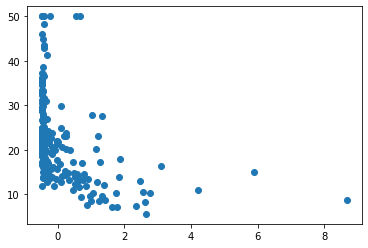

In [8]:
from sklearn.datasets import load_boston
import numpy as np

data = load_boston()

x_ = data['data']
y_ = data['target']
N_tr = int(x_.shape[0] * 0.5)
N_val = x_.shape[0] - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s

D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [9]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [10]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device=torch.device('cpu')

class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, num_nodes).train(False)
        self.fc2 = nn.Linear(num_nodes, num_nodes).train(False)
        self.fc3 = nn.Linear(num_nodes, 1).train(False)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def load_sampled_weights(self, l_1_w, l_1_b, l_2_w, l_2_b, l_3_w, l_3_b):
        self.fc1.weight = nn.Parameter(l_1_w.reshape(self.fc1.weight.shape))
        self.fc1.bias = nn.Parameter(l_1_b.reshape(self.fc1.bias.shape))
        self.fc2.weight = nn.Parameter(l_2_w.reshape(self.fc2.weight.shape))
        self.fc2.bias = nn.Parameter(l_2_b.reshape(self.fc2.bias.shape))
        self.fc3.weight = nn.Parameter(l_3_w.reshape(self.fc3.weight.shape))
        self.fc3.bias = nn.Parameter(l_3_b.reshape(self.fc3.bias.shape))

num_nodes = 10
alpha = 1.
beta = .2
ELBO_BETA = 1.
net = Net(num_nodes=num_nodes)

# MF-VI Approx

In [12]:
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, Predictive
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro import poutine
import torch.nn as nn
import pyro
from tqdm.auto import trange, tqdm
from tqdm.notebook import trange

In [13]:
class Model_Full(PyroModule):
    def __init__(self, h1=num_nodes, h2=num_nodes):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](13, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, 13]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()
        self.log_scale = PyroSample(dist.Normal(0., 1.))

    def forward(self, x, y=None):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = torch.exp(self.log_scale)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [14]:
class Model_Fixed_L1(PyroModule):
    def __init__(self, l1_weight, l1_bias, h1=num_nodes, h2=num_nodes):
        super().__init__()
        self.fc1 = nn.Linear(13, h1).train(False)
        self.fc1.weight = nn.Parameter(l1_weight.reshape(self.fc1.weight.shape), requires_grad=False)
        self.fc1.bias = nn.Parameter(l1_bias.reshape(self.fc1.bias.shape), requires_grad=False)
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()
        self.log_scale = nn.Parameter(torch.tensor([1.]))

    def forward(self, x, y=None):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = torch.exp(self.log_scale)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, self.log_scale), obs=y)
        return mu

In [15]:
class Model_Fixed_L2(PyroModule):
    def __init__(self, l1_weight, l1_bias, l2_weight, l2_bias, h1=num_nodes, h2=num_nodes):
        super().__init__()
        self.fc1 = nn.Linear(13, h1).train(False)
        self.fc1.weight = nn.Parameter(l1_weight.reshape(self.fc1.weight.shape), requires_grad=False)
        self.fc1.bias = nn.Parameter(l1_bias.reshape(self.fc1.bias.shape), requires_grad=False)
        self.fc2 = nn.Linear(h1, h2).train(False)
        self.fc2.weight = nn.Parameter(l2_weight.reshape(self.fc2.weight.shape), requires_grad=False)
        self.fc2.bias = nn.Parameter(l2_bias.reshape(self.fc2.bias.shape), requires_grad=False)
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()
        self.log_scale = nn.Parameter(torch.tensor([1.]))

    def forward(self, x, y=None):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = torch.exp(self.log_scale)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, self.log_scale), obs=y)
        return mu

In [16]:
(D_in + 1) * num_nodes + (num_nodes + 1) * num_nodes + (num_nodes + 1) * 1

261

In [17]:
def total_param(l=[]):
    s=0
    for i in range(len(l)-1):
        s=s+l[i]*l[i+1]+l[i+1]
    return s

In [18]:
total_param([D_in, num_nodes, num_nodes, 1])

261

In [19]:
test  = Model_Full()

In [20]:
for p in test.parameters():
    print(p.shape)

In [21]:
def regression_model(x, y=None, in_size=D_in, num_nodes=num_nodes, out_size=1):
    # sample vector of weights for regression
    total_weights = (in_size + 1) * num_nodes + (num_nodes + 1) * num_nodes + (num_nodes + 1) * out_size
    weights = pyro.sample("weights", dist.Normal(0., 1.).expand([total_weights]))
    
    fc1 = nn.Linear(in_size, num_nodes).train(False)
    idx = 0
    fc1_weights = weights[idx: idx + D_in * num_nodes]
    fc1.weight = nn.Parameter(fc1_weights.reshape(fc1.weight.shape))
    idx += D_in * num_nodes
    fc1_bias = weights[idx: idx + num_nodes]
    fc1.weight = nn.Parameter(fc1_bias.reshape(fc1.bias.shape))
    idx += num_nodes
    
    fc2 = nn.Linear(num_nodes, num_nodes).train(False)
    fc2_weights = weights[idx: idx + num_nodes * num_nodes]
    fc2.weight = nn.Parameter(fc2_weights.reshape(fc2.weight.shape))
    idx += num_nodes * num_nodes
    fc2_bias = weights[idx: idx + num_nodes]
    fc2.bias = nn.Parameter(fc2_bias.reshape(fc2.bias.shape))
    idx += num_nodes
    
    fc3 = nn.Linear(num_nodes, out_size).train(False)
    fc3_weights = weights[idx: idx + num_nodes * out_size]
    fc3.weight = nn.Parameter(fc3_weights.reshape(fc3.weight.shape))
    idx += num_nodes * out_size
    fc3_bias = weights[idx: idx + out_size]
    fc3.bias = nn.Parameter(fc3_bias.reshape(fc3.bias.shape))
    idx += out_size
    
    assert idx == total_weights, "Something wrong with number of weights!"
    
    # compute forward pass
    x = torch.relu(fc1(x))
    x = torch.relu(fc2(x))
    mu = fc3(x).squeeze()
    sigma = 1.
    with pyro.plate("data", x.shape[0]):
        obs = pyro.sample(dist.Normal(mu, sigma), obs=y)
    return mu
    

In [22]:
# create models
model = regression_model(x_train, y_train)
kernel = HMC(model, step_size=0.001, num_steps=5, target_accept_prob=0.65)
#nuts_kernel = NUTS(model, step_size=0.001, target_accept_prob=0.65, max_tree_depth=5)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=1500, num_chains=1)
mcmc.run(x_train, y_train)

RuntimeError: mat2 must be a matrix, got 1-D tensor

In [343]:
class KDE(PyroModule):
    def __init__(self, weight_samples, h1=num_nodes, h2=num_nodes):
        super().__init__()
        self.weight_samples = weight_samples[:, :-1]
        self.n_samples = weight_samples.shape[0]
        self.likelihood_log_sigmas = weight_samples[:, -1]
        self.h1 = h1
        self.h2 = h2
        self.fc1 = PyroModule[nn.Linear](13, self.h1)
        self.fc2 = PyroModule[nn.Linear](self.h1, self.h2)
        self.fc3 = PyroModule[nn.Linear](self.h2, 1)

    def model(self, x, y=None):      
        log_scale = PyroSample(dist.Normal(0., 1.))
        sigma = torch.exp(log_scale)
        with pyro.plate("data", x.shape[0]):
            self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([self.h1, 13]).to_event(2))
            self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([self.h1]).to_event(1))
            
            self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([self.h2,self.h1]).to_event(2))
            self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([self.h2]).to_event(1))
            
            self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1,self.h2]).to_event(2))
            self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
            
            x = nn.ReLU(self.fc1(x))
            x = nn.ReLU(self.fc2(x))
            mu = self.fc3(x).squeeze()
            likelihood_sigma = torch.exp(self.likelihood_log_sigmas)[assignment]
            obs = pyro.sample("obs", dist.Normal(mu, likelihood_sigma), obs=y)
        return mu
    
    def guide(self, x, y=None):        
        # load and sample first layer
        idx = 0
        fc1_w = self.weight_samples[:, idx:idx + 13 * self.h1].reshape(self.n_samples , *self.fc1.weight.shape)
        idx += 13 * self.h1
        fc1_b = self.weight_samples[:, idx:idx + self.h1].reshape(self.n_samples , *self.fc1.bias.shape)
        idx += self.h1
        
        # load and sample second layer
        fc2_w = self.weight_samples[:, idx:idx + self.h1 * self.h2].reshape(self.n_samples , *self.fc2.weight.shape)
        idx += self.h1 * self.h2
        fc2_b = self.weight_samples[:, idx:idx + self.h2].reshape(self.n_samples , *self.fc2.bias.shape)
        idx += self.h2

        
        # load and sample second layer
        fc3_w = self.weight_samples[:, idx:idx + self.h2].reshape(self.n_samples , *self.fc3.weight.shape)
        idx += self.h2
        fc3_b = self.weight_samples[:, idx:idx + 1].reshape(self.n_samples , *self.fc3.bias.shape)
        
        log_scale = pyro.param('log_scale', torch.tensor([1.]))
        sigma = torch.exp(log_scale)

        assignment = torch.randint(low=0, high=self.n_samples, size=(1,)).squeeze()

        print(assignment)
        self.fc1.sigma = sigma
        self.fc1.weight = PyroSample(lambda self: dist.Normal(fc1_w[assignment], self.sigma).expand([10, 13]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(fc1_b[assignment], sigma).expand([self.h1]).to_event(1))

        self.fc2.weight = PyroSample(dist.Normal(fc2_w[assignment], sigma).expand([self.h2,self.h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(fc2_b[assignment], sigma).expand([self.h2]).to_event(1))

        self.fc3.weight = PyroSample(dist.Normal(fc3_w[assignment], sigma).expand([1,self.h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(fc3_b[assignment], sigma).expand([1]).to_event(1))

        x = nn.ReLU(self.fc1(x))
        x = nn.ReLU(self.fc2(x))
        mu =  self.fc3(x).squeeze()

        likelihood_sigma = torch.exp(self.likelihood_log_sigmas)[assignment]


    def infer_parameters(self, x, y, lr=0.01, num_epochs=30):
        optim = pyro.optim.Adam({"lr" : lr})
        elbo = Trace_ELBO()
        svi = SVI(self.model, self.guide, optim, elbo)
        for i in range(num_epochs):
            loss = svi.step(x, y)
            print(f"[Epoch {i + 1}] loss: {loss:.3f}")
            
    def forward(self, x, n_samples=1):
        res = []
        for i in range(n_samples):
            t = poutine.trace(self.guide).get_trace(x)
            res.append(t.nodes['obs']['value'])
        return torch.stack(res, dim=0) 

In [344]:
kde = KDE(flattened_samples)

In [345]:
flattened_samples.shape

torch.Size([500, 262])

In [346]:
x_train.shape

torch.Size([253, 13])

In [347]:
kde(x_train)

tensor(182)


RuntimeError: fc1.weight is already in the trace as a param
Trace Shapes:      
 Param Sites:      
   fc1.weight 10 13
     fc1.bias    10
   fc2.weight 10 10
     fc2.bias    10
   fc3.weight  1 10
     fc3.bias     1
    log_scale     1
Sample Sites:      

(1, 2, 3)

In [ ]:
130 *

In [15]:
def ensemble_ll_pyro_model(m, s, x, y):
    sigmas = s['sigma']
    preds = Predictive(m, s, return_sites=['obs'])(x, None)
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=sigmas)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm.log_prob(y)

In [38]:
# create models
model = Model_Full()
kernel = HMC(model, step_size=0.001, num_steps=5, target_accept_prob=0.65)
#nuts_kernel = NUTS(model, step_size=0.001, target_accept_prob=0.65, max_tree_depth=5)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=1500, num_chains=1)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 2000/2000 [00:06, 325.26it/s, step size=1.21e-01, acc. prob=0.817]


In [39]:
hmc_samples = mcmc.get_samples(500, group_by_chain=False)

In [356]:
hmc_samples.shape

AttributeError: 'dict' object has no attribute 'shape'

In [40]:
from pyro.infer import Predictive
pred = Predictive(model, hmc_samples, return_sites=['obs'])(x_val, None)

In [41]:
sigmas = torch.exp(hmc_samples['log_scale'])
mix = D.Categorical(torch.ones(pred['obs'].shape[0]))
comp = D.Normal(loc=pred['obs'].squeeze().permute(1, 0), scale=sigmas)
gmm = D.MixtureSameFamily(mix, comp)

In [42]:
gmm.log_prob(y_val).mean()

tensor(-2.8036)

In [43]:
((pred['obs'].mean(0) - y_val) ** 2).sqrt().mean()

tensor(2.6113)

In [65]:
num_nodes * num_nodes

100

In [357]:
flattened_samples = torch.cat([l.reshape(500, -1) for l in list(hmc_samples.values())], dim=1)

In [358]:
flattened_samples.shape

torch.Size([500, 262])

In [57]:
prior = D.MultivariateNormal(loc=torch.zeros(flattened_samples.shape[-1]), covariance_matrix=torch.eye(flattened_samples.shape[-1]))

In [59]:
from models.BNNs.BNN_KDE_BOSTON import BNN_KDE

In [60]:
kde = BNN_KDE(flattened_samples[:, :-1], input_size=D_in, num_nodes=num_nodes, sigmas=flattened_samples[:, -1])

In [63]:
kde.batch_regression(kde.emp_samples, x_val, 1)

RuntimeError: shape '[1, 10, 10]' is invalid for input of size 50000

In [ ]:
single_sample_l1 = mcmc.get_samples(1)

In [ ]:
conditined_model_l1 = Model_Fixed_L1(l1_weight=single_sample_l1['fc1.weight'], l1_bias=single_sample_l1['fc1.bias'])

kernel = HMC(conditined_model_l1, step_size=0.005, num_steps=25, target_accept_prob=0.65)
mcmc = MCMC(kernel, num_samples=1500, warmup_steps=500, num_chains=1)
mcmc.run(x_train, y_train)

In [ ]:
hmc_samples_l1 = mcmc.get_samples(1000)

In [ ]:
pred = Predictive(model, hmc_samples_l1)(x_val, None)

In [ ]:
((pred['obs'].mean(0) - y_val) ** 2).sqrt().mean()

In [ ]:
emp_bnn = make_empirical_gmm(pred['obs'])

In [ ]:
emp_bnn.log_prob(y_val).sum()

In [ ]:
single_sample_l2 = mcmc.get_samples(1)

In [ ]:
conditined_model_l2 = Model_Fixed_L2(l1_weight=single_sample_l1['fc1.weight'], l1_bias=single_sample_l1['fc1.bias'],
                                     l2_weight=single_sample_l2['fc2.weight'], l2_bias=single_sample_l2['fc2.bias'])

kernel = HMC(conditined_model_l2, step_size=0.005, num_steps=25, target_accept_prob=0.65)
mcmc = MCMC(kernel, num_samples=1500, warmup_steps=500, num_chains=1)
mcmc.run(x_train, y_train)

In [ ]:
hmc_samples_l2 = mcmc.get_samples(1000)

In [ ]:
pred = Predictive(model, hmc_samples_l2)(x_val, None)

In [ ]:
((pred['obs'].mean(0) - y_val) ** 2).sqrt().mean()

In [ ]:
emp_bnn = make_empirical_gmm(pred['obs'])

In [ ]:
emp_bnn.log_prob(y_val).sum()

In [ ]:
torch.cat([hmc_samples['fc1.weight'], hmc_samples['fc1.bias']])

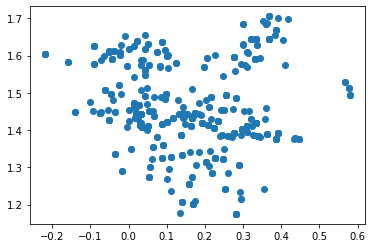

In [37]:
plt.scatter(torch.cat([l.reshape(500, -1) for l in list(hmc_samples.values())], dim=1)[:, 0],torch.cat([l.reshape(500, -1) for l in list(hmc_samples.values())], dim=1)[:, 5])